In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Evaluation:
1. Evaluate on the pretrained models: download the pretrained model [here](https://drive.google.com/drive/folders/1G1GOA0FthtmOERJIJ0pALOSgXc6XOfoY) (credit: caiyuanhao)
2. Evaluate on the models retrained with Hyper-Skin data: 
3. Do step 1-2 for (RGB, VIS) data, and only step 2 for (MSI, NIR) data (reason, all pretrained model is based on input with in_channels = 3)
4. For all, compute the SSIM (for spatial evaluation) and SAM (for spectral evaluation)

In [2]:
import os 
import cv2 
import pickle
import spectral
import spectral.io.envi as envi
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torchvision import transforms
from torchmetrics import SpectralAngleMapper, StructuralSimilarityIndexMeasure

from hsiData import HyperSkinData
from utils import metrics 
from models.reconstruction import MST_Plus_Plus, HSCNN_Plus, hrnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_dir = 'E:/hyper-skin-data'
rgbvis_dir = f'{data_dir}/Hyper-Skin(RGB, VIS)'
mask_dir = f'{data_dir}/mask'
pretrained_dir  = 'pretrained-models/hyper-skin/vis'

# directories to the test data 
rgb_dir = f'{rgbvis_dir}/RGB_CIE/test'
vis_dir = f'{rgbvis_dir}/VIS/test'
mask_dir = f'{mask_dir}/test'

# directory to save the results
results_dir = 'E:/vis-nir-evaluation-results/pretrained-hyper-skin'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [4]:
test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
test_dataset = HyperSkinData.Load(
            hsi_dir = vis_dir,
            rgb_dir = rgb_dir, 
            transform = test_transform
    )
test_loader = torch.utils.data.DataLoader(
                                    dataset = test_dataset, 
                                    batch_size = 1, 
                                    shuffle = False,
                                    pin_memory = False)

1. Evaluation: HRNET (Pretrained on NTIRE)

In [5]:
# load the pretrained model from NTIRE 
model = hrnet.SGN(in_channels=3, out_channels=31)
checkpoint = torch.load(f'{pretrained_dir}/hrnet')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
model.to(device)
model.eval() 
results = {
    "file": [],
    "pred": [],
    "ssim_score": [],
    "ssim_map": [],
    "sam_score": [],
    "sam_map": []
}
metrics.ssim_fn.to(device)
for k, data in enumerate(test_loader):
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    with torch.no_grad():
        pred = model(x)

    ssim_score, ssim_map = metrics.ssim_fn(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results["pred"].append(pred.cpu().detach().numpy())
    results["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results["sam_score"].append(sam_score.cpu().detach().numpy())
    results["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results['file'][-1]}, SSIM: {results['ssim_score'][-1]}, SAM: {results['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/hrnet.pkl', 'wb') as f:
    pickle.dump(results, f)

Test [0/30]: p005_neutral_front, SSIM: 0.9472305178642273, SAM: 0.14926517009735107
Test [1/30]: p005_neutral_front, SSIM: 0.8561198115348816, SAM: 0.194391131401062
Test [2/30]: p005_neutral_front, SSIM: 0.9292467832565308, SAM: 0.14617937803268433
Test [3/30]: p005_neutral_front, SSIM: 0.9463340044021606, SAM: 0.14911335706710815
Test [4/30]: p005_neutral_front, SSIM: 0.9238525629043579, SAM: 0.14729391038417816
Test [5/30]: p005_neutral_front, SSIM: 0.9413668513298035, SAM: 0.16446231305599213
Test [6/30]: p005_neutral_front, SSIM: 0.9449964165687561, SAM: 0.1354411244392395
Test [7/30]: p005_neutral_front, SSIM: 0.9463945627212524, SAM: 0.14808830618858337
Test [8/30]: p005_neutral_front, SSIM: 0.9383485913276672, SAM: 0.136753112077713
Test [9/30]: p005_neutral_front, SSIM: 0.9440887570381165, SAM: 0.13541094958782196
Test [10/30]: p005_neutral_front, SSIM: 0.9354425072669983, SAM: 0.15179042518138885
Test [11/30]: p005_neutral_front, SSIM: 0.9357022047042847, SAM: 0.1382167488336

In [7]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9332 +/- 0.0210
SAM: 0.1467 +/- 0.0144


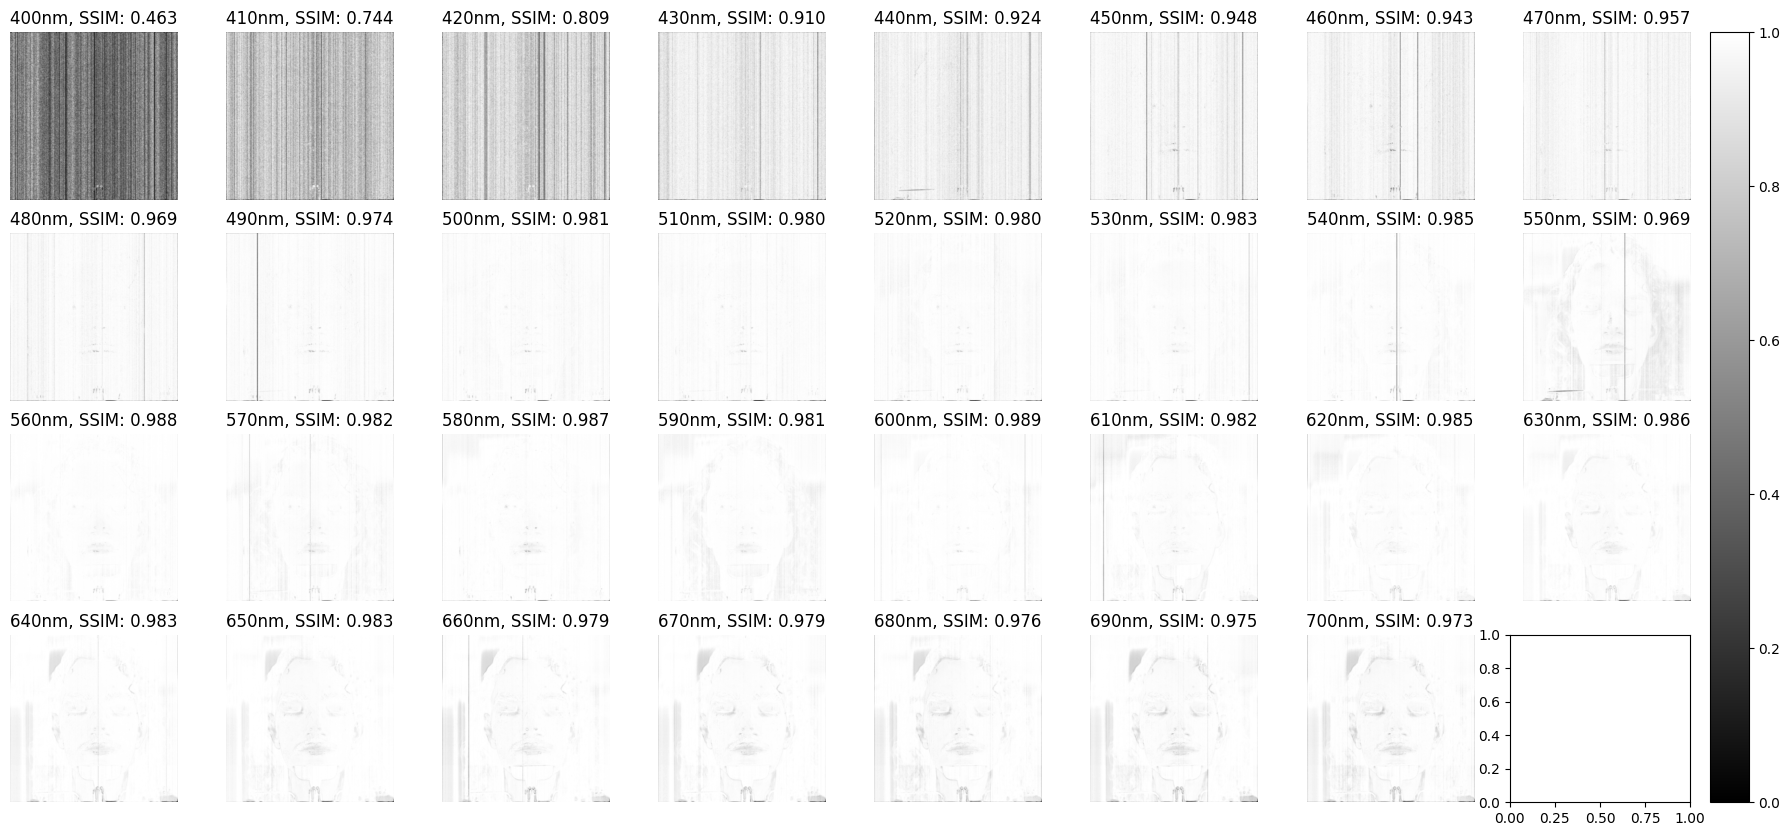

In [8]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(400, 710, 10)
ssim_map = np.array(results["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

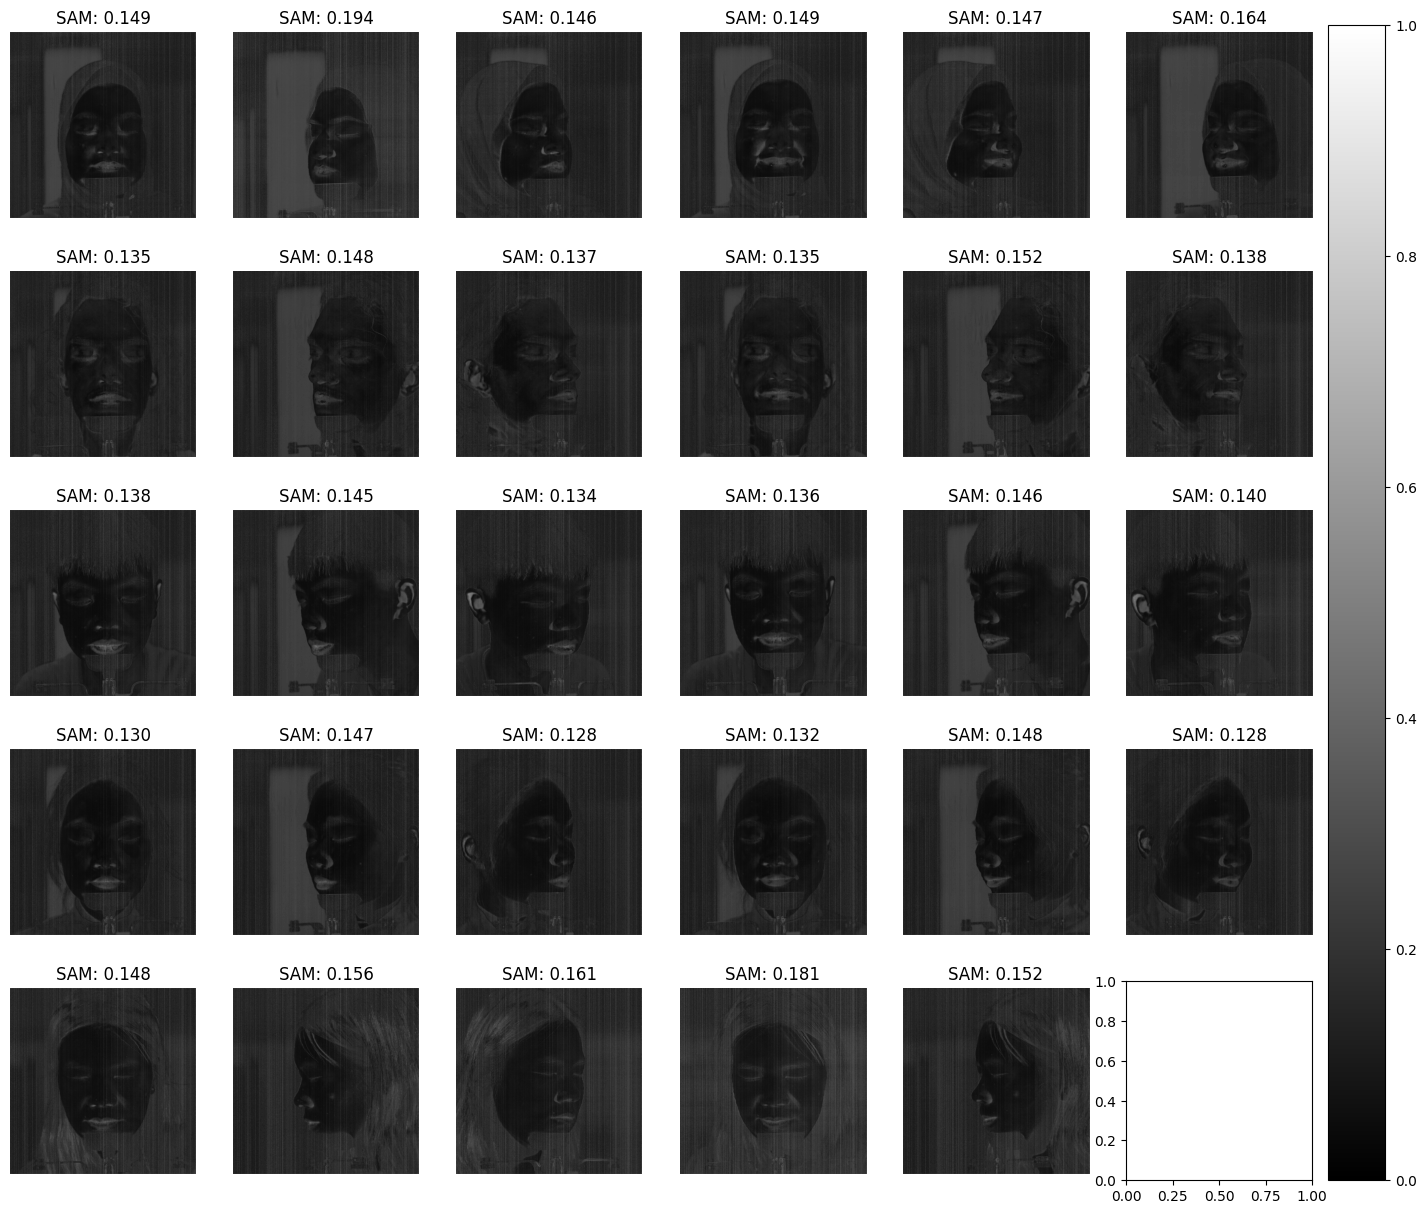

(30, 1024, 1024)

In [9]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [10]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

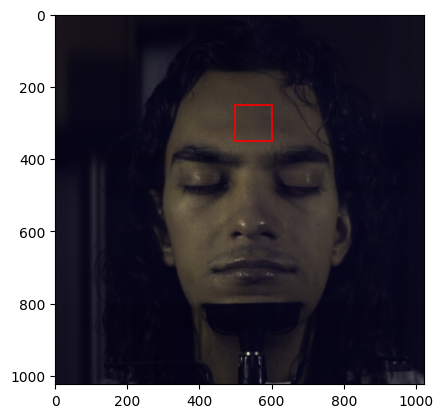

In [268]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

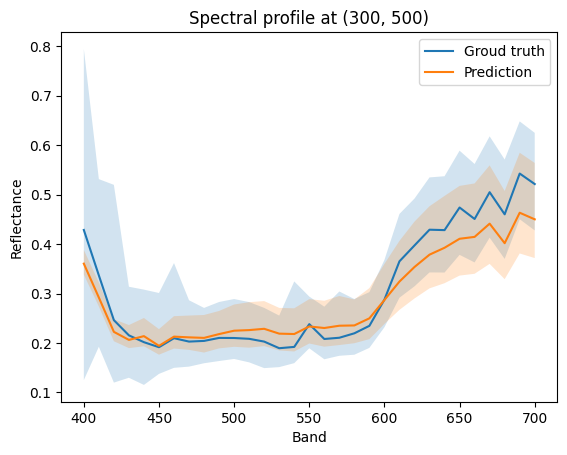

In [11]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()

1. only evaluate on the human subject - discard the background

In [12]:
model.to(device)
model.eval() 
results_m = {
    "file": [],
    "pred": [],
    "ssim_score": [],
    "ssim_map": [],
    "sam_score": [],
    "sam_map": []
}
masks = sorted(os.listdir(mask_dir))
for k, data in enumerate(test_loader):
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    mask = plt.imread(f"{mask_dir}/{masks[k]}")/255
    mask = torch.from_numpy(mask[:,:,0]).float().to(device)

    with torch.no_grad():
        pred = model(x)
        pred = pred * mask[None, None, ...]
        y = y * mask[None, None, ...]

    ssim_score, ssim_map = metrics.ssim_fn.to(device)(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results_m["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results_m["pred"].append(pred.cpu().detach().numpy())
    results_m["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results_m["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results_m["sam_score"].append(sam_score.cpu().detach().numpy())
    results_m["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results_m['file'][-1]}, SSIM: {results_m['ssim_score'][-1]}, SAM: {results_m['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/masked_hrnet.pkl', 'wb') as f:
    pickle.dump(results_m, f)

Test [0/30]: p005_neutral_front, SSIM: 0.9771792888641357, SAM: 0.12969404458999634
Test [1/30]: p005_neutral_front, SSIM: 0.9331232905387878, SAM: 0.17269599437713623
Test [2/30]: p005_neutral_front, SSIM: 0.9636531472206116, SAM: 0.14043965935707092
Test [3/30]: p005_neutral_front, SSIM: 0.976667046546936, SAM: 0.13037678599357605
Test [4/30]: p005_neutral_front, SSIM: 0.9601147770881653, SAM: 0.14363957941532135
Test [5/30]: p005_neutral_front, SSIM: 0.9750713109970093, SAM: 0.13181418180465698
Test [6/30]: p005_neutral_front, SSIM: 0.966361939907074, SAM: 0.12818248569965363
Test [7/30]: p005_neutral_front, SSIM: 0.9717045426368713, SAM: 0.12292078137397766
Test [8/30]: p005_neutral_front, SSIM: 0.9614012837409973, SAM: 0.12968088686466217
Test [9/30]: p005_neutral_front, SSIM: 0.9676527976989746, SAM: 0.12541386485099792
Test [10/30]: p005_neutral_front, SSIM: 0.9689102172851562, SAM: 0.12140879780054092
Test [11/30]: p005_neutral_front, SSIM: 0.9617401957511902, SAM: 0.1297824233

In [13]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results_m["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results_m["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9605 +/- 0.0137
SAM: 0.1334 +/- 0.0153


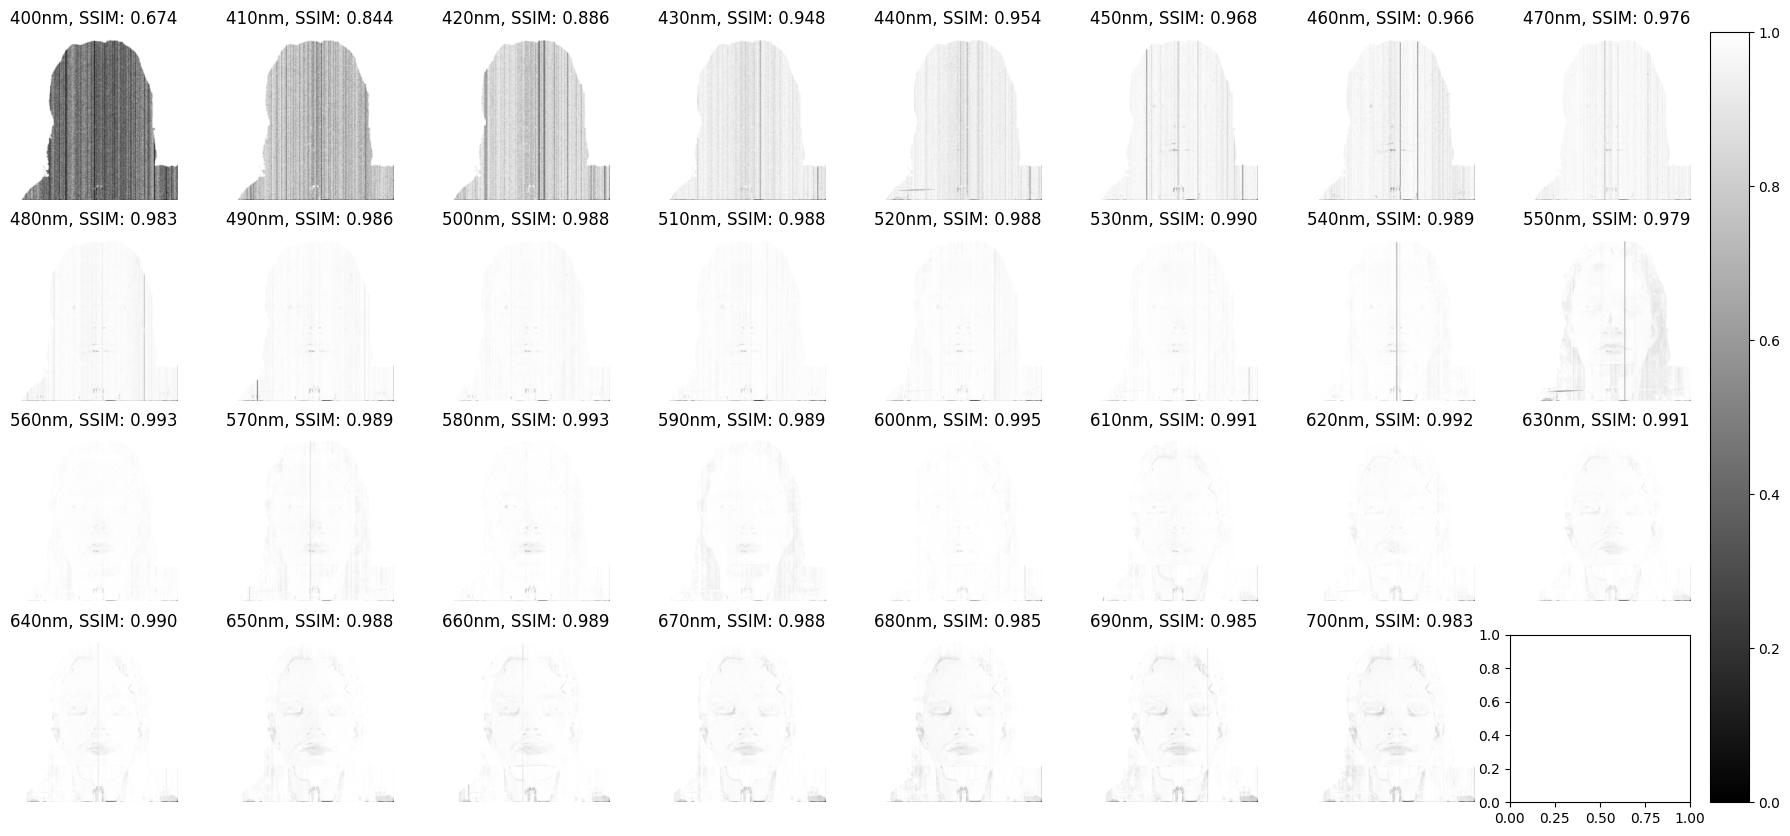

In [14]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(400, 710, 10)
ssim_map = np.array(results_m["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

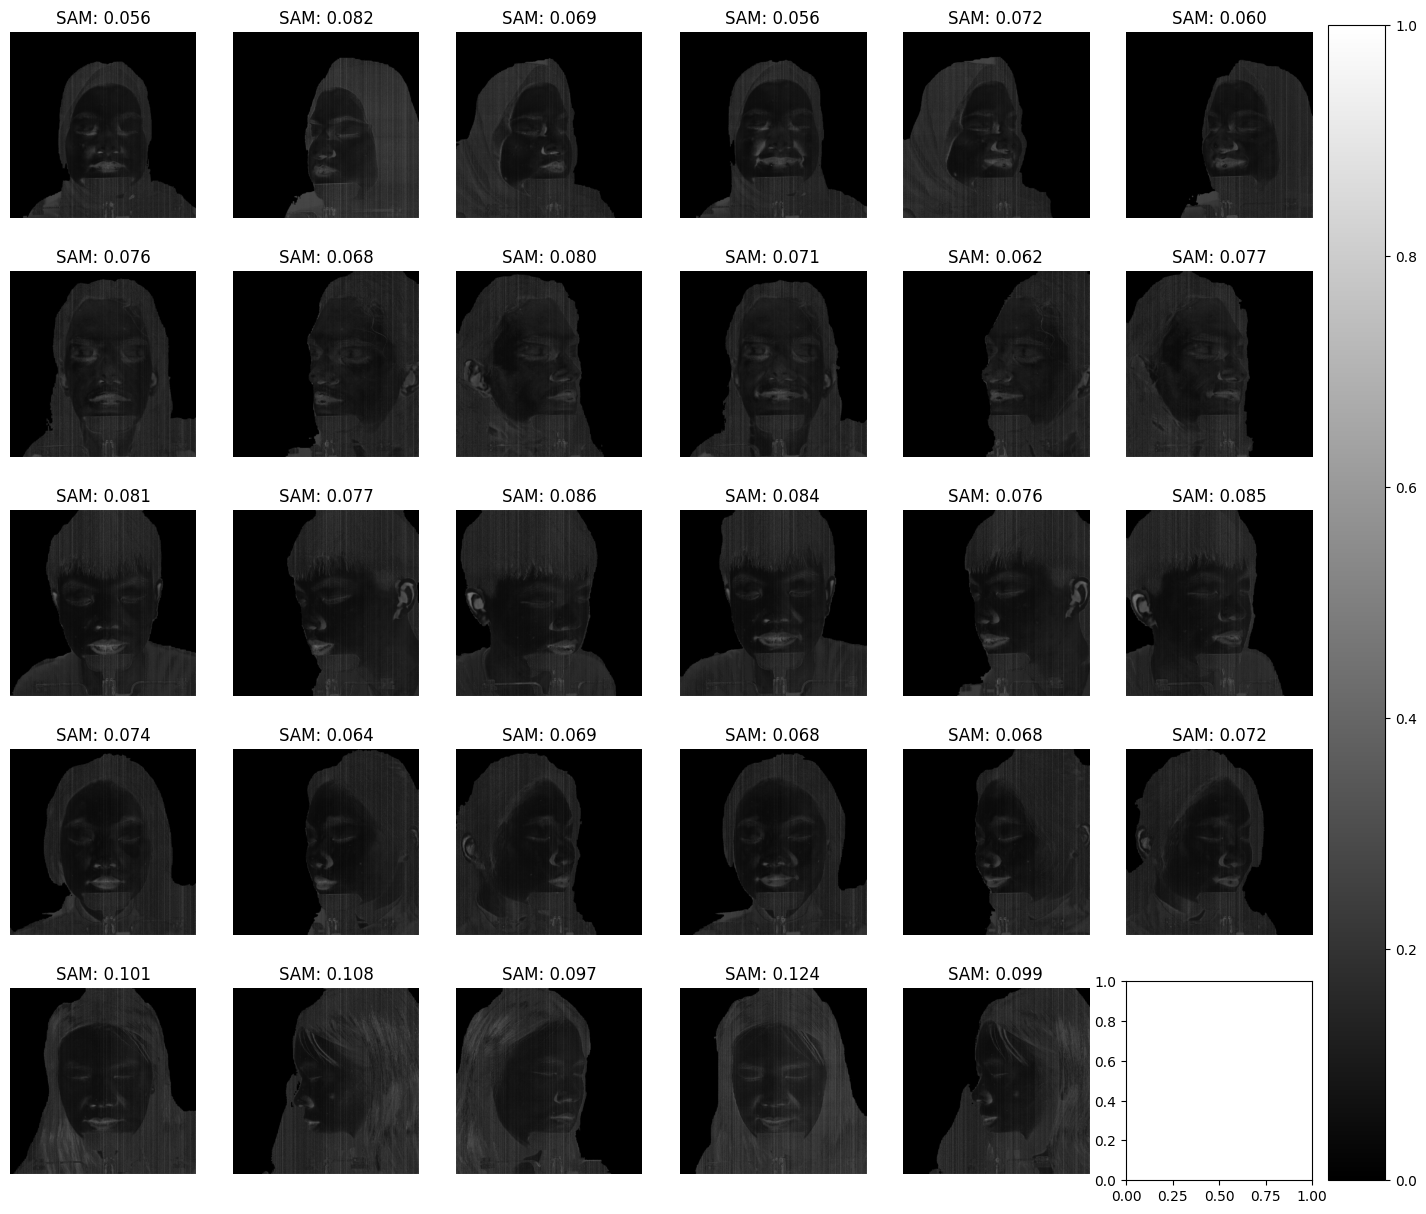

(30, 1024, 1024)

In [15]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results_m["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [16]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results_m["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

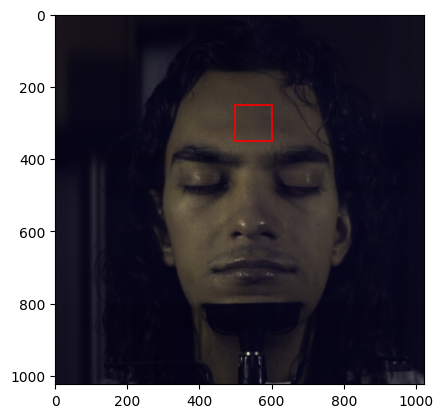

In [23]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

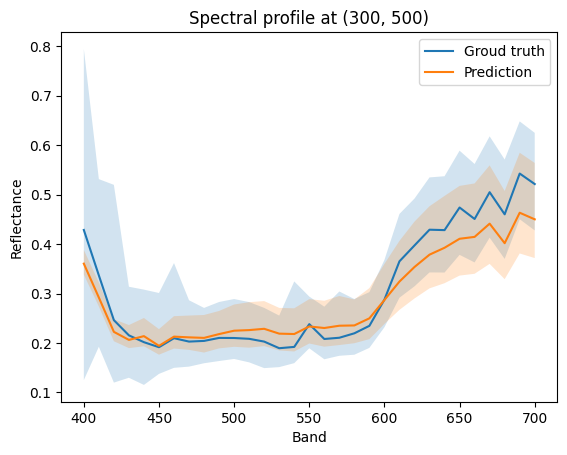

In [17]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()